In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install colorama

In [ ]:
from datetime import datetime, date

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization
from colorama import Fore

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

np.random.seed(2022)

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/AIConnect/Traffic_forecast/trainvalidtest_not999.csv") # 10 번 도로 only
df = data.copy()
df.tail()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3475,20200524,19,314226,98345,10625,28618,8316,6684,141675,6619,23535,8572,67748,16791,33325,19124,42183,63229,13163,35383,73188,100849,84286,26458,15572,10341,139827,8254,16118,23304,14082,8447,21694,2180,15746,10903,21014
3476,20200524,20,300001,87871,8226,22706,6981,5743,142933,6295,20953,7851,61609,14119,30216,18610,35556,59070,12788,30675,68255,95107,76441,24140,13340,8872,142469,5225,15297,21919,14526,7332,19732,1990,14096,10028,17787
3477,20200524,21,304150,71126,6002,18317,4939,3779,133110,4781,15242,6101,48336,11534,25710,15651,27467,53787,12019,26317,61169,86434,61136,21076,9317,6392,138816,4072,12685,21135,14403,5443,16967,1359,11670,7963,14041
3478,20200524,22,236751,44947,3575,11455,3135,2536,98582,3267,8849,4553,33607,8069,18293,9723,16602,38615,8703,17694,47609,58492,37501,12090,5901,3938,100767,2489,8093,14427,10914,3861,11397,859,7270,5194,8230
3479,20200524,23,143609,26137,2242,6166,1609,1391,54633,1899,5182,2422,20343,5104,11331,5413,9455,22150,5370,10032,31124,34013,20205,6104,3782,2272,55574,1343,4686,8732,6986,2161,6487,410,3963,2686,4690


In [ ]:
# 날짜 column  -> DateTime type 변경 + 시간대 병합
df.rename(columns = {'날짜' : 'DateTime'}, inplace = True)
df.rename(columns = {'시간' : 'Hour'}, inplace = True)
df['DateTime'] = df['DateTime'].astype(str)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['DateTime'] = df['DateTime'] + pd.to_timedelta(df['Hour'], unit='h')
df.drop('Hour', axis='columns', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  3480 non-null   datetime64[ns]
 1   10        3480 non-null   int64         
 2   100       3480 non-null   int64         
 3   101       3480 non-null   int64         
 4   120       3480 non-null   int64         
 5   121       3480 non-null   int64         
 6   140       3480 non-null   int64         
 7   150       3480 non-null   int64         
 8   160       3480 non-null   int64         
 9   200       3480 non-null   int64         
 10  201       3480 non-null   int64         
 11  251       3480 non-null   int64         
 12  270       3480 non-null   int64         
 13  300       3480 non-null   int64         
 14  301       3480 non-null   int64         
 15  351       3480 non-null   int64         
 16  352       3480 non-null   int64         
 17  370       3480

In [ ]:
# 10번 도로만 ㅇㅇ
df_10 = df[['DateTime', '10']]

In [ ]:
df_10.head()

,DateTime,10
0,2020-01-01 00:00:00,83247
1,2020-01-01 01:00:00,89309
2,2020-01-01 02:00:00,66611
3,2020-01-01 03:00:00,53290
4,2020-01-01 04:00:00,52095


In [ ]:
# 요일, 월, 일 feature 생성 (Feature engineering )

df_10["Month"]= df_10['DateTime'].dt.month  
df_10["Date_no"]= df_10['DateTime'].dt.day
df_10["Hour"]= df_10['DateTime'].dt.hour
df_10["Day"]= df_10.DateTime.dt.strftime("%A")
df_10.tail()

,DateTime,10,Month,Date_no,Hour,Day
3475,2020-05-24 19:00:00,314226,5,24,19,Sunday
3476,2020-05-24 20:00:00,300001,5,24,20,Sunday
3477,2020-05-24 21:00:00,304150,5,24,21,Sunday
3478,2020-05-24 22:00:00,236751,5,24,22,Sunday
3479,2020-05-24 23:00:00,143609,5,24,23,Sunday


In [ ]:
# Simplify column names
df_10.columns = ['DateTime', '10', 'Month', 'Date_no', 'Hour', 'Day']

targets = ['10']
features = [feature for feature in df_10.columns if feature not in targets]
df_10.head()

,DateTime,10,Month,Date_no,Hour,Day
0,2020-01-01 00:00:00,83247,1,1,0,Wednesday
1,2020-01-01 01:00:00,89309,1,1,1,Wednesday
2,2020-01-01 02:00:00,66611,1,1,2,Wednesday
3,2020-01-01 03:00:00,53290,1,1,3,Wednesday
4,2020-01-01 04:00:00,52095,1,1,4,Wednesday


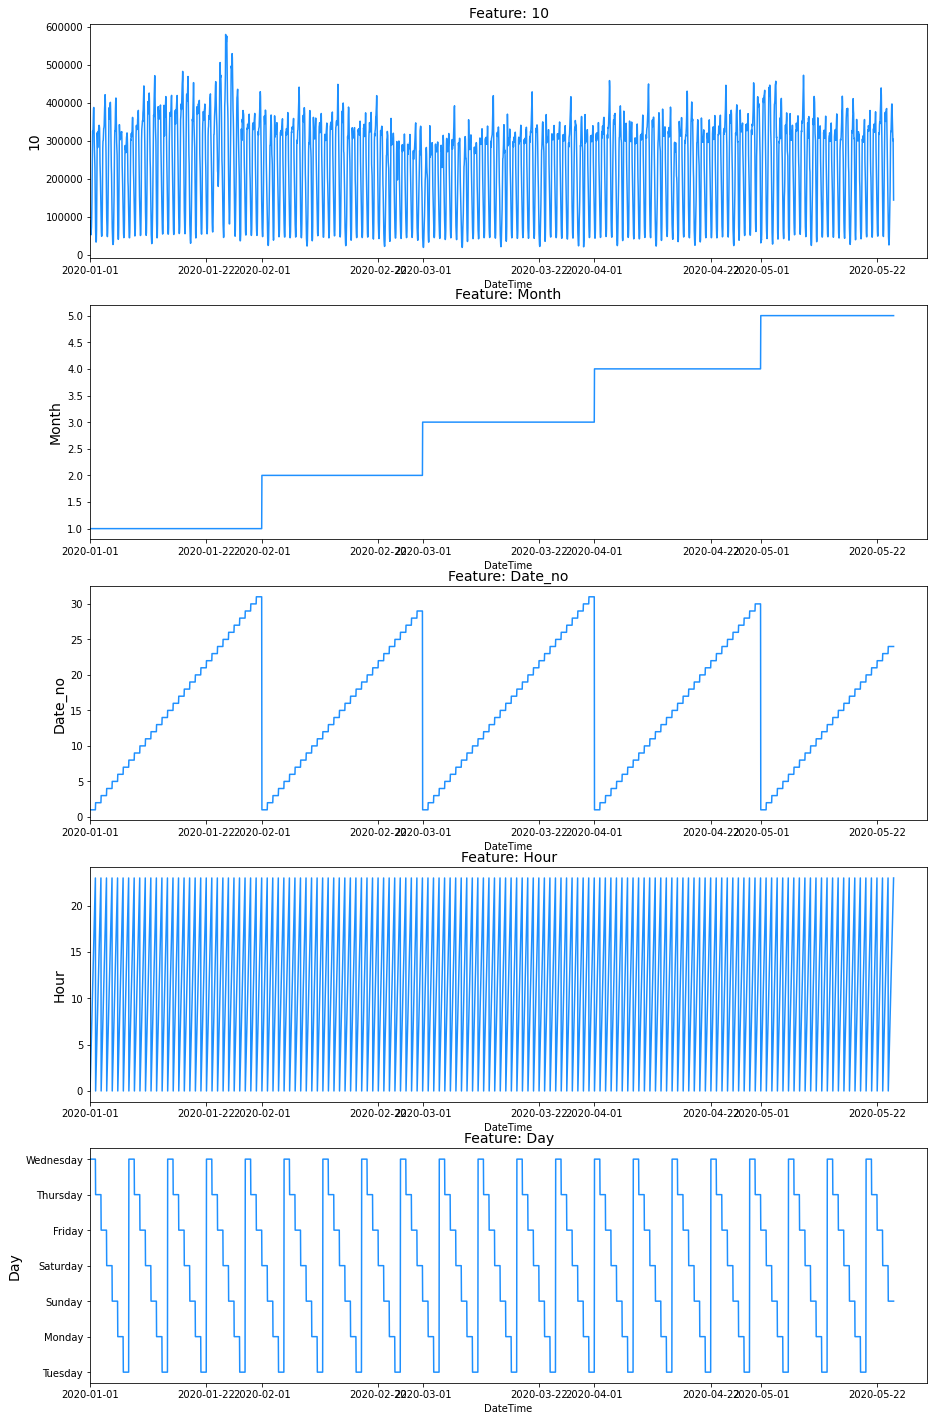

In [ ]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df_10.drop('DateTime', axis=1).columns):
    sns.lineplot(x=df_10['DateTime'], y=df_10[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2020, 1, 1), date(2020, 5, 31)])  

# Stationarity  정상성  (시간에 따른 패턴이 일정하니 ?)


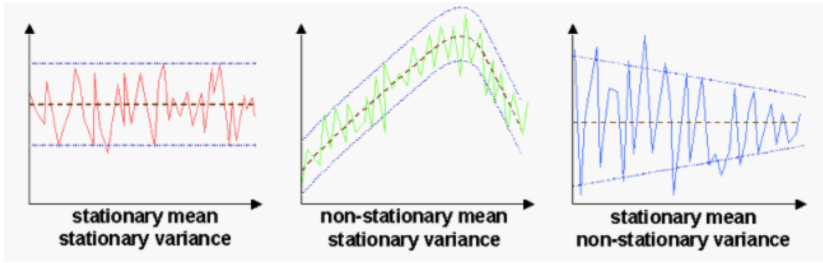

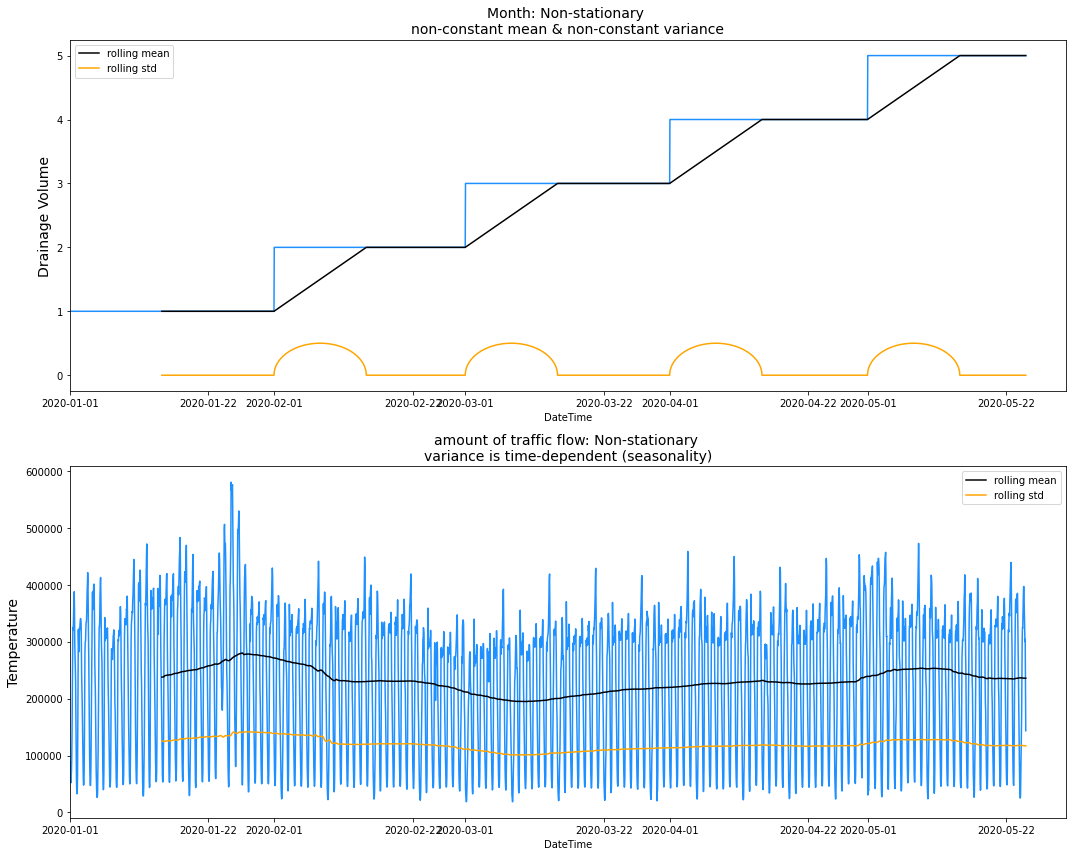

In [ ]:

#  24 hours * 7days * 2 << which i want to set as some kinda seasonality
rolling_window = 24*7*2
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df_10['DateTime'], y=df_10['Month'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df_10['DateTime'], y=df_10['Month'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df_10['DateTime'], y=df_10['Month'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Month: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2020, 1, 1), date(2020, 5, 31)])

sns.lineplot(x=df_10['DateTime'], y=df_10['10'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df_10['DateTime'], y=df_10['10'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df_10['DateTime'], y=df_10['10'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('amount of traffic flow: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2020, 1, 1), date(2020, 5, 31)])

plt.tight_layout()
plt.show()

# Augmented Dickey-Fuller (ADF)
* Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

* Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

* If the null hypothesis can be rejected, we can conclude that the time series is stationary.

* There are two ways to rejects the null hypothesis:

* On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

* **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_10['10'].values)
result

(-6.7721329416291836,
 2.6255429411204615e-09,
 30,
 3449,
 {'1%': -3.4322474118861863,
  '10%': -2.5672162784688224,
  '5%': -2.8623783679235006},
 76486.28854501912)

In [ ]:
# p 값이  1.861912762581912e-08 로 매우 작으므로 시계열성을 갖는다 ??

# 아래 그래프에서는 심지어 0.000 으로 나옴

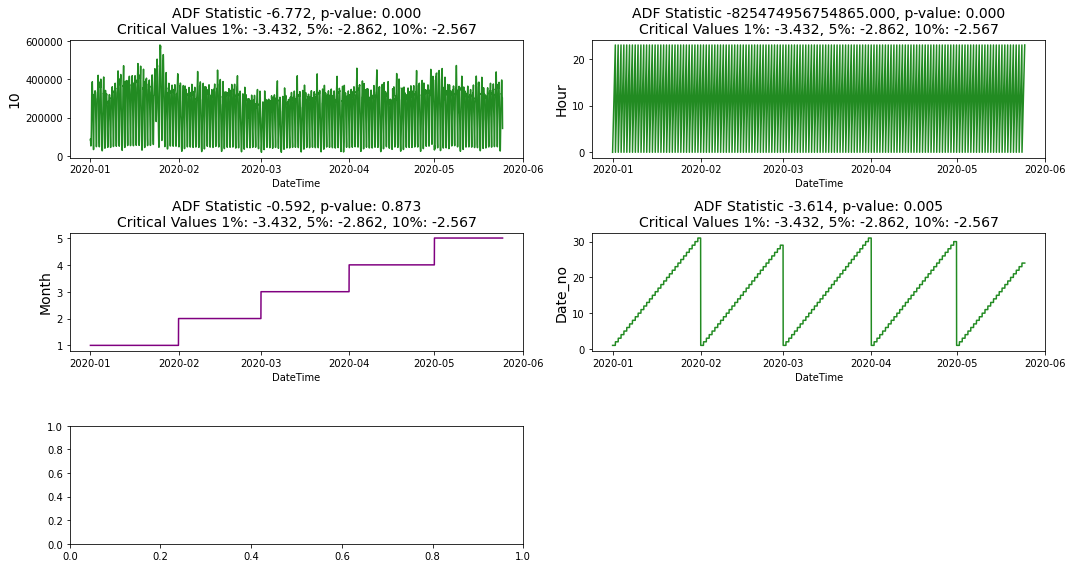

In [ ]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df_10['DateTime'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df_10['10'].values, '10', ax[0, 0])
visualize_adfuller_results(df_10['Month'].values, 'Month', ax[1, 0])
visualize_adfuller_results(df_10['Hour'].values, 'Hour', ax[0, 1])
visualize_adfuller_results(df_10['Date_no'].values, 'Date_no', ax[1, 1])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

# Transforming
* Log Transform of absolute values
* (Log transoform of negative values will return NaN)

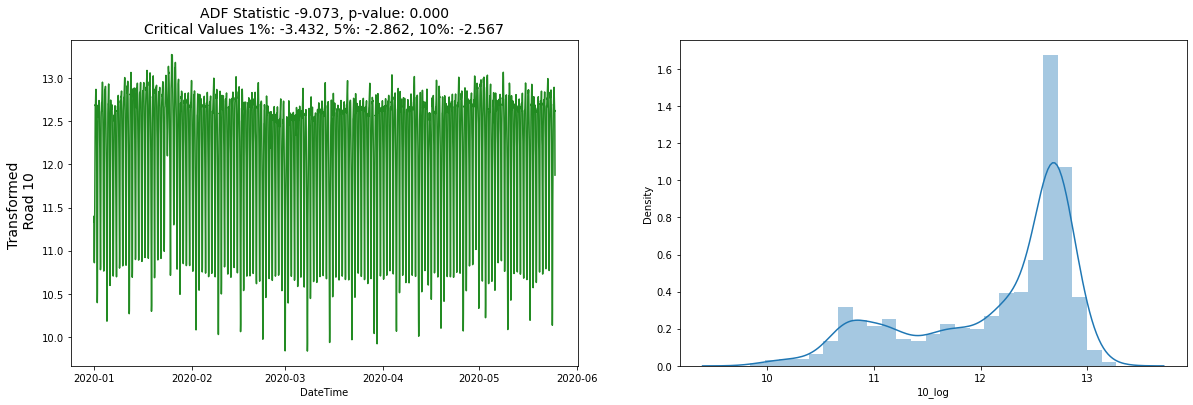

In [ ]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df_10['10_log'] = np.log(abs(df_10['10']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df_10['10_log'], 'Transformed \n Road 10', ax[0])

sns.distplot(df_10['10_log'], ax=ax[1])

# Differencing

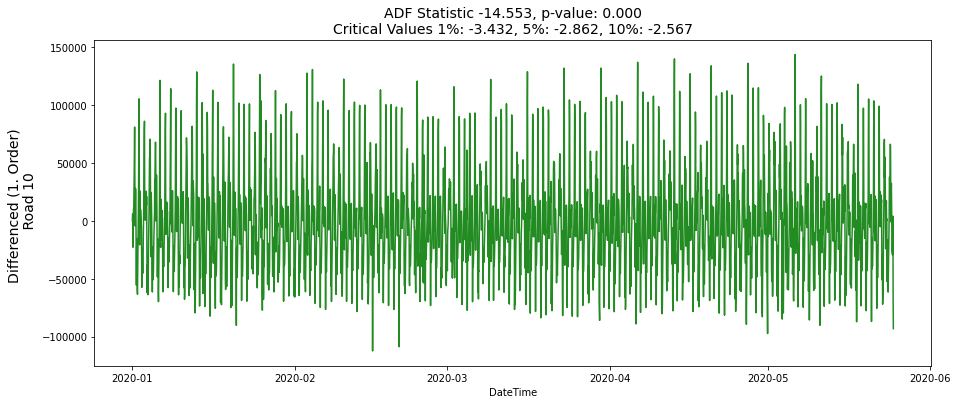

In [ ]:
# First Order Differencing
ts_diff = np.diff(df_10['10'])
df_10['10_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df_10['10_diff_1'], 'Differenced (1. Order) \n Road 10', ax)

In [ ]:
# 주기성 시간 Feature 몇개 추가

df_10['day_of_year'] = pd.DatetimeIndex(df_10['DateTime']).dayofyear
df_10['week_of_year'] = pd.DatetimeIndex(df_10['DateTime']).weekofyear
df_10['quarter'] = pd.DatetimeIndex(df_10['DateTime']).quarter
df_10['season'] = df_10['Month'] % 12 // 3 + 1

df_10[['DateTime', 'Month', 'Day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,DateTime,Month,Day,day_of_year,week_of_year,quarter,season
0,2020-01-01 00:00:00,1,Wednesday,1,1,1,1
1,2020-01-01 01:00:00,1,Wednesday,1,1,1,1
2,2020-01-01 02:00:00,1,Wednesday,1,1,1,1
3,2020-01-01 03:00:00,1,Wednesday,1,1,1,1
4,2020-01-01 04:00:00,1,Wednesday,1,1,1,1


In [ ]:
df_10[['DateTime', 'Month', 'Day', 'day_of_year', 'week_of_year', 'quarter', 'season']].tail()

,DateTime,Month,Day,day_of_year,week_of_year,quarter,season
3475,2020-05-24 19:00:00,5,Sunday,145,21,2,2
3476,2020-05-24 20:00:00,5,Sunday,145,21,2,2
3477,2020-05-24 21:00:00,5,Sunday,145,21,2,2
3478,2020-05-24 22:00:00,5,Sunday,145,21,2,2
3479,2020-05-24 23:00:00,5,Sunday,145,21,2,2


# Encoding Cyclical Features
* The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

* 월, 시간 같은 주기성 feature 는 모델에 혼란을 줄 수 있으므로  encoding 이 필요하다고 함. ㅇㅇ.

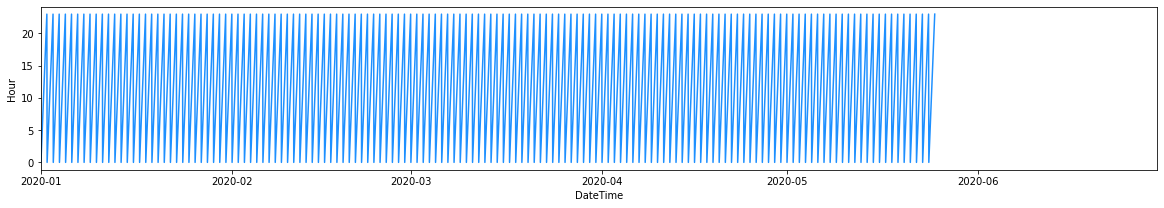

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df_10['DateTime'], y=df_10['Hour'], color='dodgerblue')
ax.set_xlim([date(2020, 1, 1), date(2020, 6, 30)])
plt.show()

## Lets encode this cyclical feature:
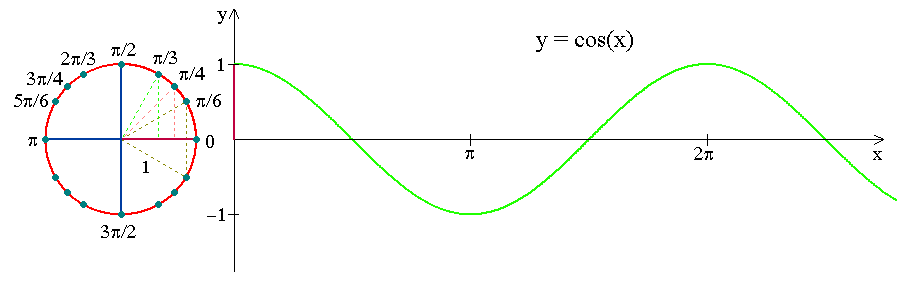

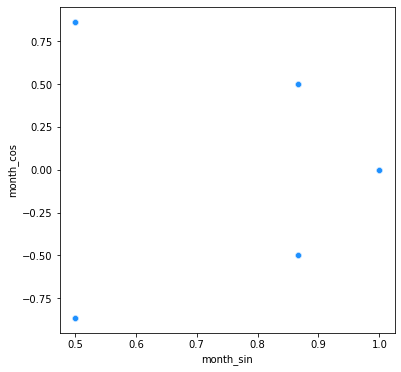

In [ ]:
month_in_year = 12
df_10['month_sin'] = np.sin(2*np.pi*df_10['Month']/month_in_year)
df_10['month_cos'] = np.cos(2*np.pi*df_10['Month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df_10.month_sin, y=df_10.month_cos, color='dodgerblue')
plt.show()

#  TimeSeries Decomposition
* Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

* These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.
* Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

* All series have a level and noise. The trend and seasonality components are optional.

* It is helpful to think of the components as combining either additively or multiplicatively:

Additive:  
y
(
t
)
=
L
e
v
e
l
+
T
r
e
n
d
+
S
e
a
s
o
n
a
l
i
t
y
+
N
o
i
s
e
 
Multiplicative:  
y
(
t
)
=
L
e
v
e
l
∗
T
r
e
n
d
∗
S
e
a
s
o
n
a
l
i
t
y
∗
N
o
i
s
e
 
* In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [ ]:
!pip install statsmodels

Found existing installation: statsmodels 0.13.2
Uninstalling statsmodels-0.13.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/statsmodels-0.13.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/statsmodels/*
Proceed (y/n)? y
  Successfully uninstalled statsmodels-0.13.2
  Using cached statsmodels-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


In [ ]:
import statsmodels
print(statsmodels.__version__)

0.13.2


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    '10','Hour', 'Date_no'
]

for column in core_columns:
    decomp = seasonal_decompose(df_10[column], period=168*2, model='additive', extrapolate_trend='freq')
    df_10[f"{column}_trend"] = decomp.trend
    df_10[f"{column}_seasonal"] = decomp.seasonal

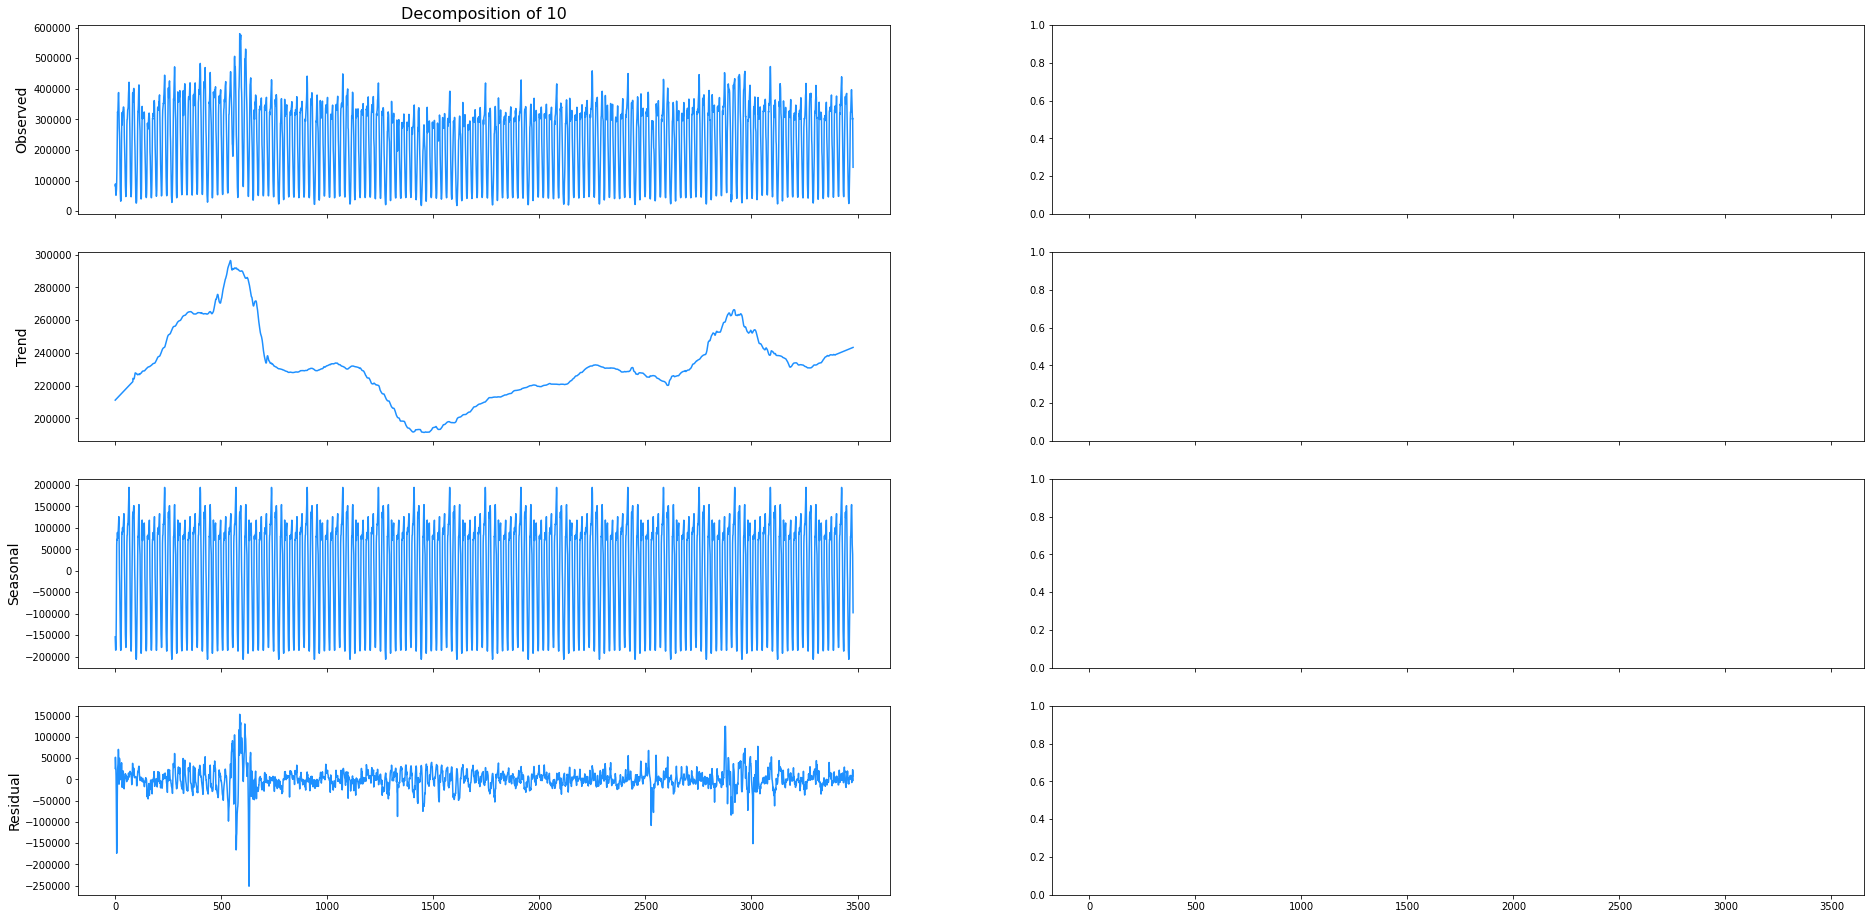

In [ ]:
# 1주 간격으로 시계열 분해
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(32,16))

for i, column in enumerate(['10']):
    
    res = seasonal_decompose(df_10[column], period=24*7, model='additive', extrapolate_trend='freq')

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

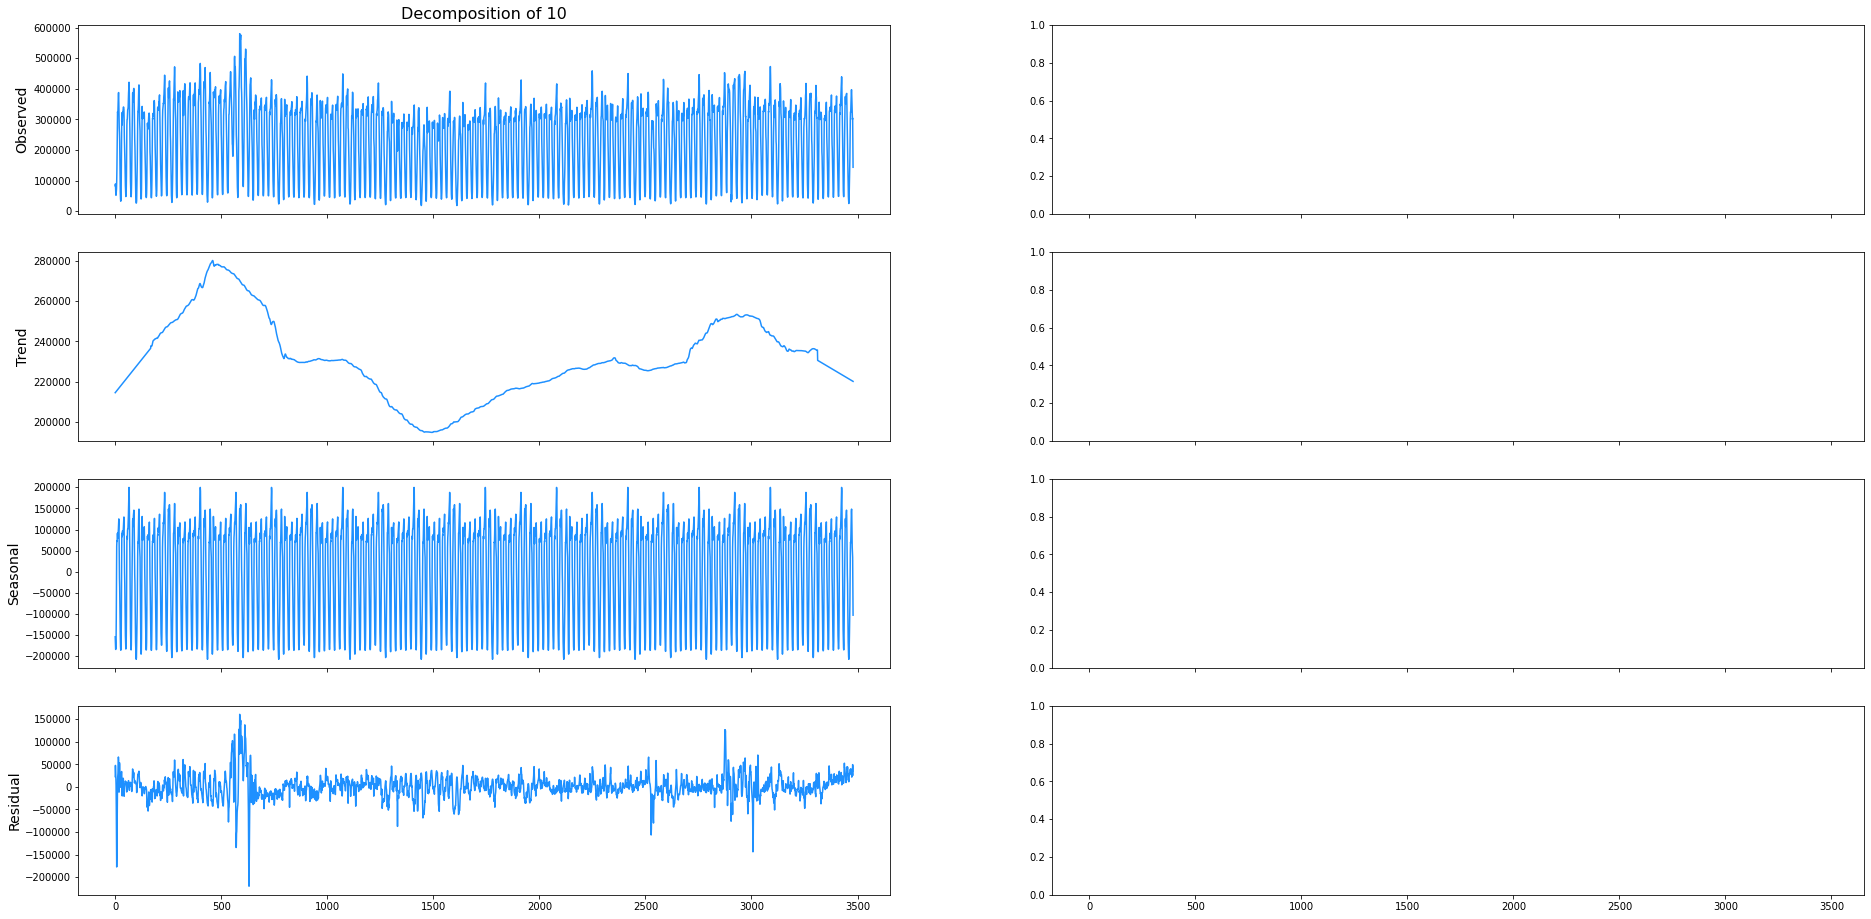

In [ ]:
# 2주 간격으로 시계열 분해
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(32,16))

for i, column in enumerate(['10']):
    
    res = seasonal_decompose(df_10[column], period=24*7*2, model='additive', extrapolate_trend='freq') 

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [ ]:
df_10

,DateTime,10,Month,Date_no,Hour,Day,day_of_year,week_of_year,quarter,season,month_sin,month_cos,10_trend,10_seasonal,Hour_trend,Hour_seasonal,Date_no_trend,Date_no_seasonal
0,2020-01-01 00:00:00,83247,1,1,0,Wednesday,1,1,1,1,0.5,0.866025,214602.628557,-153826.413982,11.5,-11.5,0.520833,1.039386
1,2020-01-01 01:00:00,89309,1,1,1,Wednesday,1,1,1,1,0.5,0.866025,214734.384626,-172334.923071,11.5,-10.5,0.562500,1.033731
2,2020-01-01 02:00:00,66611,1,1,2,Wednesday,1,1,1,1,0.5,0.866025,214866.140696,-183468.819214,11.5,-9.5,0.604167,1.028076
3,2020-01-01 03:00:00,53290,1,1,3,Wednesday,1,1,1,1,0.5,0.866025,214997.896765,-183609.903303,11.5,-8.5,0.645833,1.022421
4,2020-01-01 04:00:00,52095,1,1,4,Wednesday,1,1,1,1,0.5,0.866025,215129.652835,-166835.729505,11.5,-7.5,0.687500,1.016767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3307,2020-05-17 19:00:00,311727,5,17,19,Sunday,138,20,2,2,0.5,-0.866025,239737.345926,67974.748953,11.5,7.5,0.372035,0.033135
3308,2020-05-17 20:00:00,305354,5,17,20,Sunday,138,20,2,2,0.5,-0.866025,239708.626320,56299.854843,11.5,8.5,0.334691,0.035381
3309,2020-05-17 21:00:00,306008,5,17,21,Sunday,138,20,2,2,0.5,-0.866025,239679.906713,43507.507012,11.5,9.5,0.297348,0.037627
3310,2020-05-17 22:00:00,237447,5,17,22,Sunday,138,20,2,2,0.5,-0.866025,239651.187106,-16646.618200,11.5,10.5,0.260004,0.039873


# Lag (?? lag 가 뭐죠) 일단보류 ㄱ
* We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

* You can see documentation of shift function for more information.

# Autocorrelation Analysis
* ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

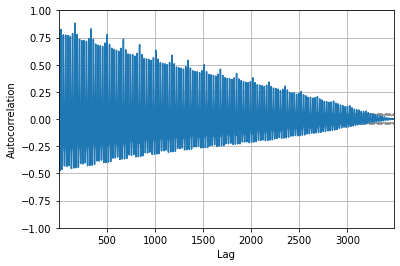

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df_10['10_diff_1'])
plt.show()

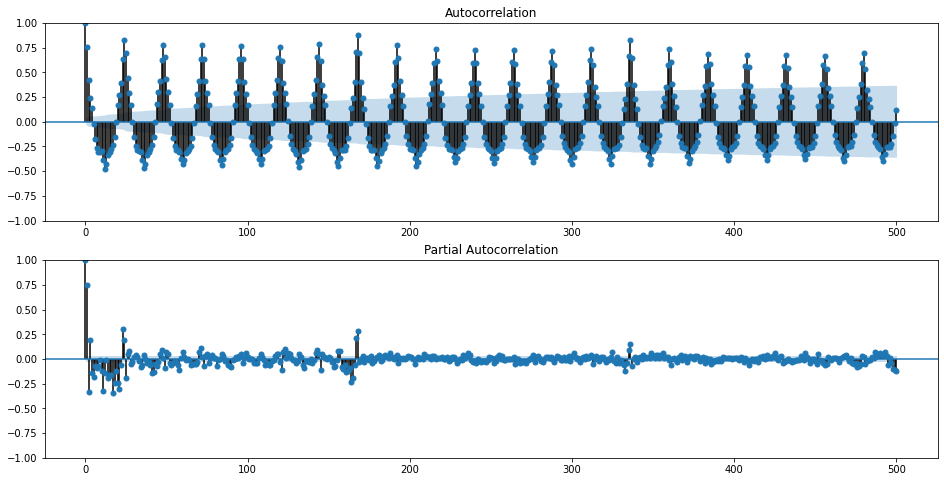

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df_10['10_diff_1'], lags=500, ax=ax[0])
plot_pacf(df_10['10_diff_1'], lags=500, ax=ax[1])

plt.show()

# Modeling

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df_10['DateTime']
y = df_10['10']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

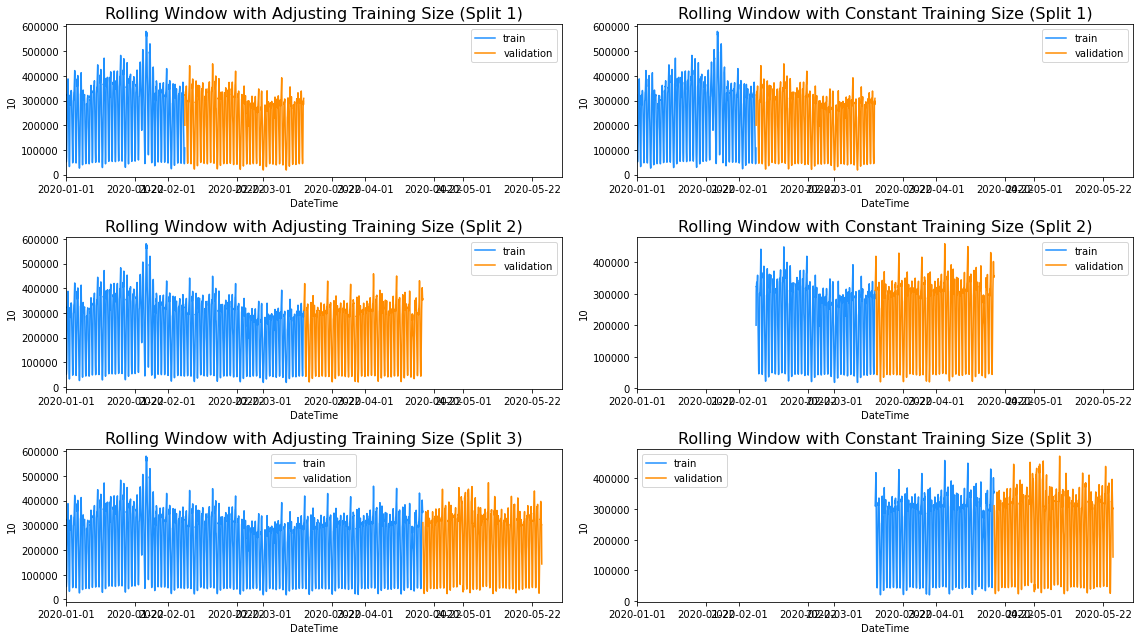

In [ ]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2020, 1, 1), date(2020, 5, 31)])
    ax[i, 1].set_xlim([date(2020, 1, 1), date(2020, 5, 31)])
    
plt.tight_layout()
plt.show()

# Model for univariate time series
* First of all, we are going to analize univariate TimeSeries forecasting.

* Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [ ]:
train_size = len(df) - 168
test_size = 168

univariate_df = df[['DateTime', '10']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

3312 168


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


RMSE: 33694.634044899736


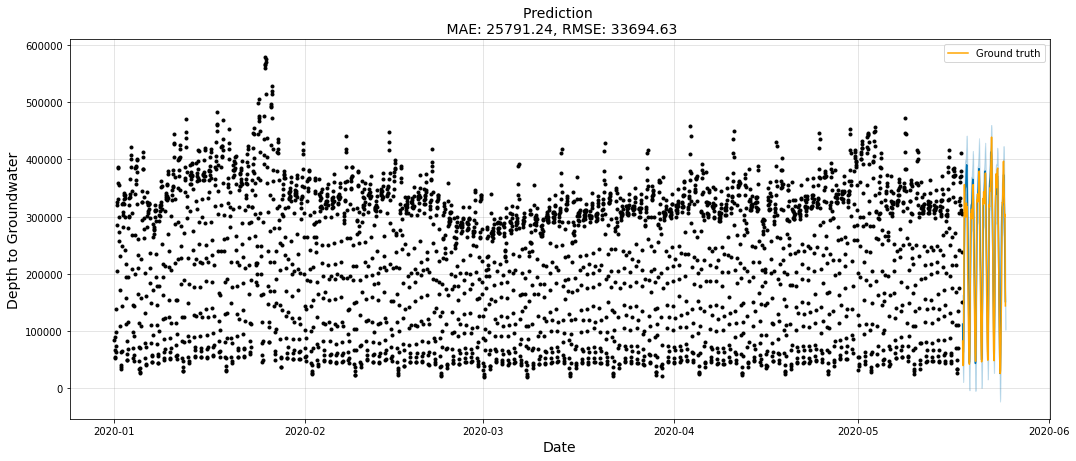

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# LSTM

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

Create the dataset, ensure all data is float.
Normalize the features.
Split into training and test sets.
Convert an array of values into a dataset matrix.
Reshape into X=t and Y=t+1.
Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [ ]:
# LSTM

from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.88507025],
       [-0.87427165],
       [-0.91470494],
       [-0.93843443],
       [-0.94056316],
       [-0.92186601],
       [-0.90368189],
       [-0.85813609],
       [-0.78705094],
       [-0.66868317]])

In [ ]:
# Defines the rolling window
look_back = 168  # 이거 조정 필수. 우리 데이터는 168 시간 (1주일) 또는 168*2 (2주일)

# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

2976 168


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=168, epochs=100, validation_data=(x_test, y_test))

model.summary()

Epoch 1/100
18/18 [==============================] - 3s 48ms/step - loss: 0.0990 - val_loss: 0.0420
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 0.0256 - val_loss: 0.0134
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0072
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0052
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0049
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0042
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 11

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 11551.052126051669


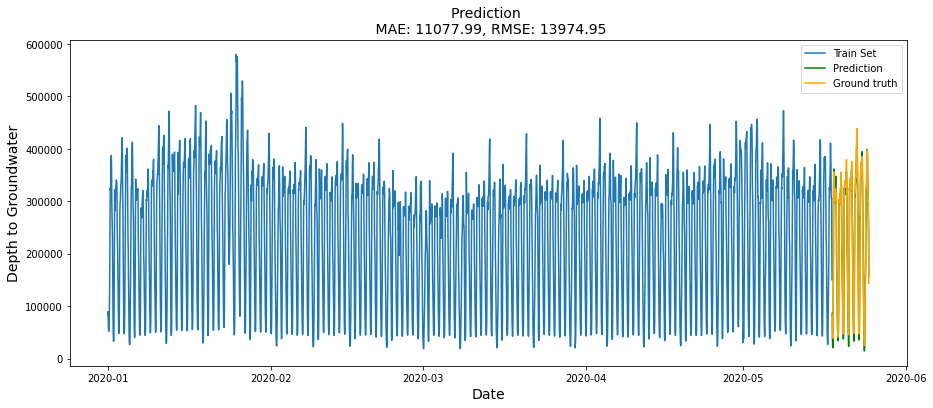

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

In [ ]:
# GRU
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 6

X = df_10['DateTime']
y = df_10['10']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.88507025],
       [-0.87427165],
       [-0.91470494],
       [-0.93843443],
       [-0.94056316],
       [-0.92186601],
       [-0.90368189],
       [-0.85813609],
       [-0.78705094],
       [-0.66868317]])

In [ ]:
# Defines the rolling window
look_back = 168  # 이거 조정 필수. 우리 데이터는 168 시간 (1주일) 또는 168*2 (2주일)

# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

2976 168


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU
import tensorflow as tf


#Build the LSTM model
callbacks = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=150,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model = Sequential()
model.add(GRU(128, activation="swish", return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(64, activation="swish", return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=84, epochs=1000, validation_data=(x_test, y_test), callbacks=[callbacks])

model.summary()

Epoch 1/1000
36/36 [==============================] - 3s 18ms/step - loss: 0.0470 - val_loss: 0.0104
Epoch 2/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0054
Epoch 3/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 4/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0054 - val_loss: 0.0037
Epoch 5/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 6/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0043 - val_loss: 0.0027
Epoch 7/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0026
Epoch 8/1000
36/36 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 9/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/1000
36/36 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.001

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

RMSE: 7596.7339721207


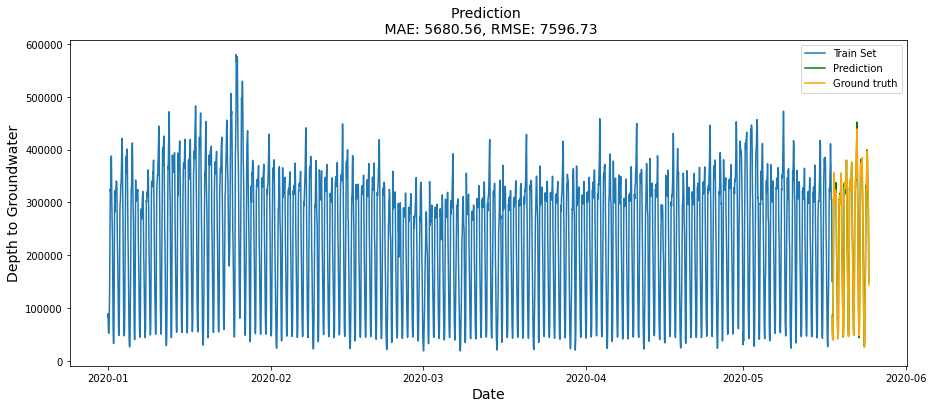

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()